In [1]:
# problem was at line : m_tmp = Euler_integrate(m[cell_idx], dt, source_term_momentum, [P[cell_idx-1:cell_idx+1], dx])
# [P[cell_idx-1:cell_idx+1] instead of [P[cell_idx:cell_idx+2]

# check what s the problem with the small peak
# try reflecting BC : no change?

In [4]:
# import libraries
import math
import matplotlib.pyplot as plt
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy
import os
import numpy as np
import glob

In [7]:
# initialize Pressure, density and internal energy for the SOD shocktube problem
def initialize_SOD_shocktube_problem(gamma, Nx, n_ghost, P, p, E, p_left, p_right, P_left, P_right):
    i_half = (Nx-4)/2 + 1
    for i in range(n_ghost, Nx-n_ghost): # goes from index 2 to index Nx-3
        if i <= i_half:
            p[i] = p_left
            P[i] = P_left
            E[i] = P_left/((gamma-1)*p_left)
        else: # i > i_half
            p[i] = p_right
            P[i] = P_right
            E[i] = P_right/((gamma-1)*p_right)
    return P, p, E

# implement outflow boundary conditions for a grid with 2 ghost cells
def outflow_BC_2(P, p, E, v, m):
    # density
    p[-1] = p[-3]
    p[-2] = p[-3]
    p[0] = p[2]
    p[1] = p[2]
    
    # Pressure
    P[-1] = P[-3]
    P[-2] = P[-3]
    P[0] = P[2]
    P[1] = P[2]
    
    # Energy
    E[-1] = E[-3]
    E[-2] = E[-3]
    E[0] = E[2]
    E[1] = E[2]
    
    #velocity
    v[-1] = v[-3]
    v[-2] = v[-3]
    v[0] = v[2]
    v[1] = v[2]
    
    # momentum
    m[-1] = m[-3]
    m[-2] = m[-3]
    m[0] = m[2]
    m[1] = m[2]
    
    return P, p, E, v, m

# display density, pressure, density and internal energy graphs
def display_graphs(P, p, v, E, output_file, Nx, n_ghost, save, display):
    plt.rcParams["figure.dpi"] = 150
    figure, axis = plt.subplots(2, 2)
    active_cells = Nx - (n_ghost * 2)
    
    # set sup array for x axis from -0.5 to 0.5
    x = [0] * active_cells
    dx = 1/active_cells
    count = x[0] = -0.5 + (dx/2) # to be symmetric
    
    for i in range(1, active_cells):
        count += dx
        x[i] = count
    
    # For Density
    axis[0, 0].plot(x, p[n_ghost : -n_ghost], c = 'b')
    axis[0, 0].set_title("Plot of Density vs Position", fontsize = 10)
    axis[0, 0].set_xticks(ticks = [-0.5, 0, 0.5])
    axis[0, 0].set_yticks(ticks = [0, 0.5, 1])
    axis[0, 0].tick_params(axis='x',labelsize=7)
    axis[0, 0].tick_params(axis='y',labelsize=7)
    axis[0, 0].set_xlabel("x (m)", fontsize = 8, labelpad = 0)
    axis[0, 0].set_ylabel("Density (kg/m^3)", fontsize = 8, labelpad = 1)
    

    # For Pressure
    axis[0, 1].plot(x, P[n_ghost : -n_ghost], c = 'g')
    axis[0, 1].set_title("Plot of Pressure vs Position", fontsize = 10)
    axis[0, 1].set_xticks(ticks = [-0.5, 0, 0.5])
    axis[0, 1].set_yticks(ticks = [0, 0.5, 1])
    axis[0, 1].tick_params(axis='x',labelsize=7)
    axis[0, 1].tick_params(axis='y',labelsize=7)
    axis[0, 1].set_xlabel("x (m)", fontsize = 8, labelpad = 0)
    axis[0, 1].set_ylabel("Pressure (Pa)", fontsize = 8, labelpad = 1)

    # For Velocity
    axis[1, 0].plot(x, v[n_ghost : -n_ghost], c = 'r')
    axis[1, 0].set_title("Plot of Velocity vs Position", fontsize = 10)
    axis[1, 0].set_xticks(ticks = [-0.5, 0, 0.5])
    axis[1, 0].set_yticks(ticks = [0, 0.5, 1])
    axis[1, 0].tick_params(axis='x',labelsize=7)
    axis[1, 0].tick_params(axis='y',labelsize=7)
    axis[1, 0].set_xlabel("x (m)", fontsize = 8, labelpad = 0)
    axis[1, 0].set_ylabel("Velocity (m/s)", fontsize = 8, labelpad = 1)

    # For Energy
    axis[1, 1].plot(x, E[n_ghost : -n_ghost], c = 'k')
    axis[1, 1].set_title("Plot of Internal Energy vs Position", fontsize = 10)
    axis[1, 1].set_xticks(ticks = [-0.5, 0, 0.5])
    axis[1, 1].set_yticks(ticks = [1, 1.5, 2, 2.5, 3, 3.5])
    axis[1, 1].tick_params(axis='x',labelsize=7)
    axis[1, 1].tick_params(axis='y',labelsize=7)
    axis[1, 1].set_ylim(1, 3.8)
    axis[1, 1].set_xlabel("x (m)", fontsize = 8, labelpad = 0)
    axis[1, 1].set_ylabel("Specific Internal Energy (J/kg)", fontsize = 8, labelpad = 1)

    plt.tight_layout()
    if save == True:
        plt.savefig(output_file)
    if display == True:
        plt.show()
    else:
        plt.close()

# create animation with moviepy library
def create_animation(folder_path, fps, step, Nt, all_P, all_p, all_v, all_E, Nx, n_ghost, output_file):
    # create folder in which we will store all images and the animation
    tmp_folder = folder_path + "/tmp"
    if os.path.exists(tmp_folder):
        files = glob.glob(tmp_folder + '/*')
        for f in files:
            os.remove(f)
    else:
        os.mkdir(tmp_folder)
    
    # create the individual images
    for nt in range(0, Nt, step):
        display_graphs(all_P[nt], all_p[nt], all_v[nt], all_E[nt], tmp_folder + "/" + str(nt) + ".png", Nx, n_ghost, True, False)
    
    file_list = np.array(sorted(glob.glob(tmp_folder + '/*.png')))
    order = np.array([int(f.split("/")[-1].split(".")[0]) for f in file_list])
    sortIx = np.argsort(order)
    file_list = list(file_list[sortIx])

    clip = mpy.ImageSequenceClip(file_list, fps=fps)
    clip.write_videofile(folder_path + "/" + output_file)    

# function to integrate with the Euler method
def Euler_integrate(x, dt, func, args):
    return x + func(x, args) * dt

# function to update internal energy with source term
def source_term_energy(x, args):
    P = args[0] # pressure value at x (space coordinate)
    v = args[1] # velocity array at x and x + dx
    dx = args[2] # delta x
    dv = (v[1] - v[0])/dx
    return -1 * P * dv

# function to update momentum with source term
def source_term_momentum(x, args):
    P = args[0] # pressure array at x and x + dx
    dx = args[1] # delta x
    dP = (P[1] - P[0])/ dx
    return - 1 * dP

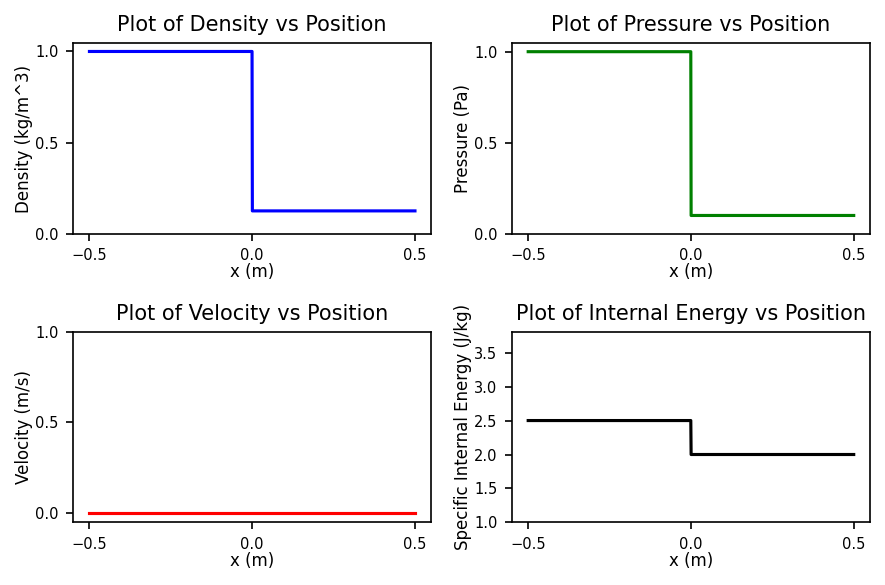

In [8]:
# STEP 1: set up grid
Nt = 1000 # number of timesteps
Nx = 1004 # active grid: indexes 2 to Nx-3
n_ghost = 2 # number of "ghost cells" on each side
dx = 1 / (Nx - (n_ghost *2))

# temporaty arrays to store values of Pressure, density, internal energy, velocity and momentum at each step
P = [0] * Nx
p = [0] * Nx
E = [0] * Nx
v = [0] * Nx
m = [0] * Nx

# STEP 2: initialization
gamma = 1.4
CFL_factor = 0.3
t = 0 # time
# initial pressure and density conditions
p_left = 1
P_left = 1
p_right = 0.125
P_right = 0.1
# for animation and plots
folder = "results"
output_file = "animation.mp4"
fps = 40
step = 2 # include image every 2 steps for animation

# initialize the arrays 
P, p, E = initialize_SOD_shocktube_problem(gamma, Nx, n_ghost, P, p, E, p_left, p_right, P_left, P_right)

# initialize the ghost cells with reflecting/outflow boundary conditions
# P, p, E, v, m = reflecting_BC_2(P, p, E, v, m)
P, p, E, v, m = outflow_BC_2(P, p, E, v, m)

display_graphs(P, p, v, E, folder + "/initial_state.png", Nx, n_ghost, True, True)

In [9]:
# arrays will store all values throughout time to display plots at the end
all_P = [[None] * (Nx) for _ in range(Nt)]
all_p = [[None] * (Nx) for _ in range(Nt)]
all_E = [[None] * (Nx) for _ in range(Nt)]
all_v = [[None] * (Nx) for _ in range(Nt)]
all_m = [[None] * (Nx) for _ in range(Nt)]

# stores the initial conditions
for i in range(Nx):
    all_P[0][i] = P[i]
    all_p[0][i] = p[i]
    all_E[0][i] = E[i]
    all_v[0][i] = v[i]
    all_m[0][i] = m[i]

In [10]:
# STEP3: loop over time
for timestep in range(1, Nt):
    # 3a: calc dt
    tmp = [math.sqrt((gamma*i)/j) for i,j in zip(P, p)]
    dt = min([dx/(abs(i)+j) for i,j in zip(v, tmp)]) * CFL_factor
    
    # STEP 3b: calc source terms using Euler method
    for cell_idx in range(n_ghost, Nx-n_ghost):
        # dE/dt (internal energy)
        E[cell_idx] = Euler_integrate(E[cell_idx], dt, source_term_energy, [P[cell_idx], v[cell_idx:cell_idx+2], dx])
        # dm/dt (momentum)
        m[cell_idx] = Euler_integrate(m[cell_idx], dt, source_term_momentum, [P[cell_idx-1:cell_idx+1], dx])
        # update v
        v[cell_idx] = (m[cell_idx]) / ((1/2) * (p[cell_idx] + p[cell_idx-1]))
        
    # now, to finish the step, call boundary ocnditions
    P, p, E, v, m = outflow_BC_2(P, p, E, v, m)   
        
    # STEP 3c: calculate advection terms
    Fp = [None] * Nx # the ghost cells will keep none value, this is to keep same indexes
    FE = [None] * Nx
    Fm = [None] * Nx
    avg_v = [None] * Nx 
    avg_Fp = [None] * Nx
    
    for cell_idx in range(n_ghost-1, Nx-n_ghost+1):
        if v[cell_idx] >= 0:
            Fp[cell_idx] = p[cell_idx-1] * v[cell_idx]
            FE[cell_idx] = (E[cell_idx-1]/p[cell_idx-1]) * Fp[cell_idx]
        else: # v[cell_idx] < 0
            Fp[cell_idx] = p[cell_idx] * v[cell_idx]
            FE[cell_idx] = (E[cell_idx]/p[cell_idx]) * Fp[cell_idx]
    
    for cell_idx in range(n_ghost-1, Nx-n_ghost):
        avg_v[cell_idx] = (1/2) * (v[cell_idx] + v[cell_idx + 1])
        avg_Fp[cell_idx] = (1/2) * (Fp[cell_idx] + Fp[cell_idx + 1])
        
        if avg_v[cell_idx] >= 0:
            Fm[cell_idx] = v[cell_idx] * avg_Fp[cell_idx]
        else: # avg_v[cell_idx] < 0
            Fm[cell_idx] = v[cell_idx + 1] * avg_Fp[cell_idx]
    
    # Update cells, only active cells this time
    for cell_idx in range(n_ghost, Nx-n_ghost):
        p[cell_idx] = p[cell_idx] - ((dt/dx) * (Fp[cell_idx + 1] - Fp[cell_idx]))
        E[cell_idx] = E[cell_idx] - ((dt/dx) * (FE[cell_idx + 1] - FE[cell_idx]))
        m[cell_idx] = m[cell_idx] - ((dt/dx) * (Fm[cell_idx] - Fm[cell_idx-1]))
        v[cell_idx] = (m[cell_idx]) / ((1/2) * (p[cell_idx] + p[cell_idx-1]))
        # update P with equation of state
        P[cell_idx] = (gamma - 1) * p[cell_idx] * E[cell_idx]
    
    # To finish the step, call boundary ocnditions
    P, p, E, v, m = outflow_BC_2(P, p, E, v, m)
    
    # STEP 3d: increment time
    t += dt
    
    # if timestep%100 == 0:
        # display_graphs(P, p, v, E, "tmp", Nx, n_ghost, False, True)
    
    # STEP 3e: store all values
    # need to store values 1 by one or it will update ALL arrays in the 2d array
    for i in range(Nx):
        all_P[timestep][i] = P[i]
        all_p[timestep][i] = p[i]
        all_E[timestep][i] = E[i]
        all_v[timestep][i] = v[i]
        all_m[timestep][i] = m[i]  

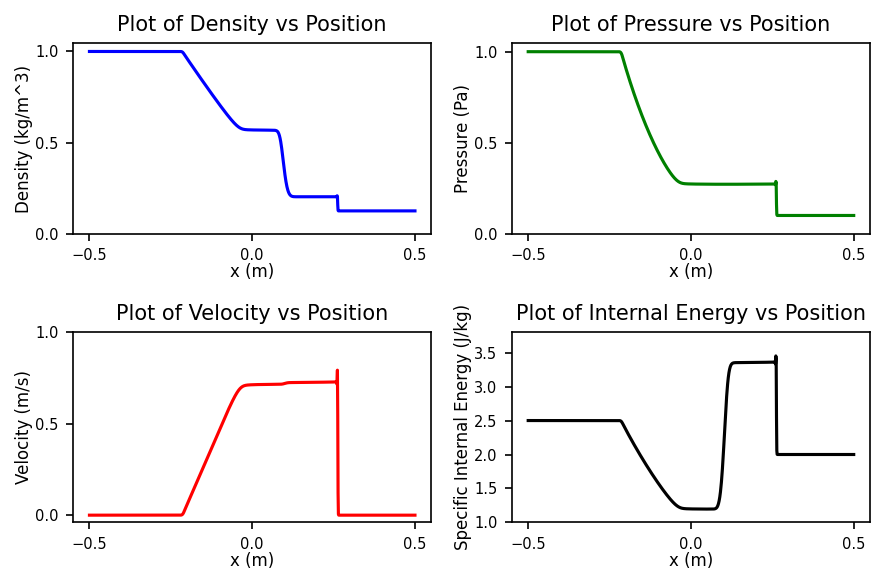

In [11]:
display_graphs(P, p, v, E, folder + "/final_state.png", Nx, n_ghost, True, True)

In [12]:
create_animation(folder, fps, step, Nt, all_P, all_p, all_v, all_E, Nx, n_ghost, output_file)

Moviepy - Building video results/animation.mp4.
Moviepy - Writing video results/animation.mp4



Moviepy - Done !
Moviepy - video ready results/animation.mp4
